# Algotytm przecinania się odcinków na płaszczyźnie

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [8]:
np.random.seed(100)

def draw_example_1():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()

def draw_segments(lines):
    vis = Visualizer()
    vis.add_line_segment(lines)
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

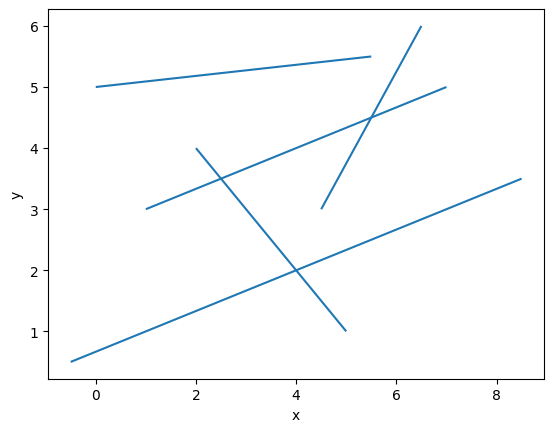

In [3]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

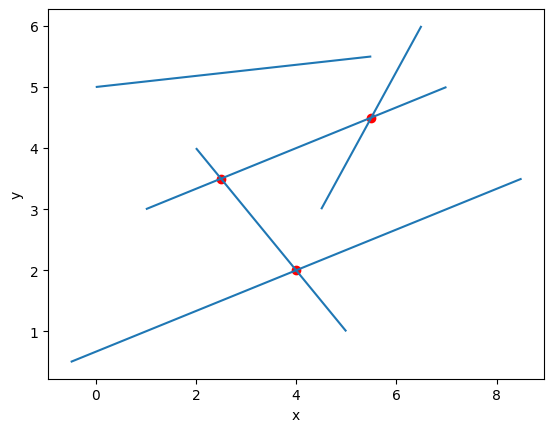

In [4]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [5]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    res = []
    for _ in range(n):
        x1 = np.random.uniform(0, max_x)
        x2 = np.random.uniform(0, max_x)
        y1 = np.random.uniform(0, max_y)
        y2 = np.random.uniform(0, max_y)
        res.append(((x1, y1), (x2, y2)))
    return res

In [6]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.112s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [7]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

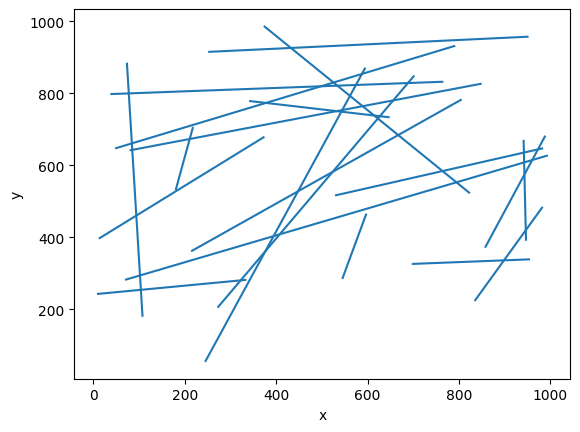

In [9]:
draw_segments(section)

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [18]:
def add_sections(n):
    '''
Żeby skorzystać z graficznego wprowadzania odcinków należy wywołać funkcję `draw_app` z argumentem, 
który oznacza liczbę prostych. Wynik można zapisać do zmiennej,
np: `sections = draw_app(10)`.
'''
    %matplotlib tk
    clicks = []

    def onclick(event):
        x = event.xdata
        y = event.ydata
        if x is not None and y is not None:
            clicks.append((x, y))

    res = []
    fig, ax = plt.subplots(figsize = (7,7))
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    while len(clicks) == 0:
        plt.pause(0.1)
    while len(clicks) == 1:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")

    while len(clicks)<2 * n:
        plt.pause(0.1)
        plt.scatter(clicks[-1][0], clicks[-1][1], marker='o', color="red")
        if len(clicks) % 2 == 0: 
            plt.plot((clicks[-1][0], clicks[-2][0]), (clicks[-1][1], clicks[-2][1]),color="blue")
            res.append(((clicks[-1][0], clicks[-1][1]), (clicks[-2][0], clicks[-2][1])))

    plt.pause(1)
    plt.close('all')
    %matplotlib inline
    return res

In [19]:
sections = add_sections(3)

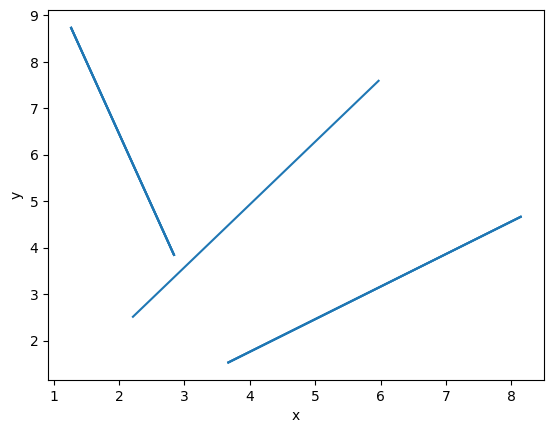

In [20]:
draw_segments(sections)

Uzupełnij funkcję ```is_intersection```

In [ ]:
def is_intersection(sections):
    """
    Funkcja sprawdepsilonza czy jakakolwiek para podanych odcinków się przecina 
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps:  będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    raise Exception("Unimplemented")

In [ ]:
Test().runtest(2, is_intersection)

### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [ ]:
def is_intersection_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    raise Exception("Unimplemented")

Uzupełnij funkcję ```find_intersections```

In [ ]:
def find_intersections(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    raise Exception("Unimplemented")

In [ ]:
Test().runtest(3, find_intersections)

Uzupełnij funkcję ```find_intersections_with_visualization```

In [ ]:
def find_intersections_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [ ]:
# testing_sections = ???

In [ ]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak? 

Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.